In [1]:
import SimpleITK as sitk
import json
import numpy as np
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import pydicom
import pandas as pd

CASE_PATH = r'C:\Users\ang.a\OneDrive - Technion\Documents\MRI_Data\clean cases\107'
ANNOTATION_DATA = r'C:\Users\ang.a\OneDrive - Technion\Documents\MRI_Data\clean cases\107\data\24.10.2021__19_29..annotation.json'

How I read the input data using in ImageUntangler using `pydicom`

In [2]:
pixel_data = []

for i in glob(f'{CASE_PATH}\*.dcm'):
    f = Path(i)
    dcm = pydicom.dcmread(f)
    
    di = {
        "zloc": float(dcm['SliceLocation'].value),
        "pixel": dcm.pixel_array
    }
    pixel_data.append(di)

df = pd.DataFrame(pixel_data)
df = df.sort_values(by="zloc")
pixel_arr = np.stack(df['pixel'].to_list())
pixel_arr = np.flipud(pixel_arr)
pixel_arr.shape

(28, 512, 512)

In [3]:
zloc = df['zloc']
zloc = zloc.reset_index()['zloc']

transform the DICOM folder to a numpy array

In [4]:
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(CASE_PATH)
reader.SetFileNames(dicom_names)
image = reader.Execute()

nda = sitk.GetArrayFromImage(image)
# nda = np.flipud(nda)

nda.shape

(28, 512, 512)

They're the same:

In [5]:
np.all(np.isclose(pixel_arr, nda))

True

although this part kinda concerns me

In [6]:
print(np.array(image.GetDirection()).reshape(3,3))

[[ 1.          0.          0.        ]
 [ 0.          0.14706708  0.98912652]
 [ 0.         -0.98912652  0.14706708]]


but sITK has a setdirection method

In [7]:
np.array([1,0,0,0,1,0,0,0,1]).reshape(3,3)

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [8]:
reader2 = sitk.ImageSeriesReader()
dicom_names2 = reader.GetGDCMSeriesFileNames(CASE_PATH)
reader2.SetFileNames(dicom_names2)
image2 = reader2.Execute()
image2.SetDirection([1,0,0,0,1,0,0,0,1])

nda2 = sitk.GetArrayFromImage(image2)
nda2 = np.flipud(nda2)

nda2.shape

(28, 512, 512)

and now it's different

In [9]:
np.all(np.isclose(pixel_arr, nda2))

False

The annotation:

In [10]:
# open and read the annotation data
with open(ANNOTATION_DATA, 'r') as f: 
    annotation_points = json.load(f)
    data = annotation_points['MPR points']

data = np.array(data)
data[-1] 

array([ -32.21047691, -137.17608698,   -4.44367695])

In [11]:
z_dict = {i: image2.TransformIndexToPhysicalPoint([0,0,i])[2] for i in range(image2.GetDepth())}
z_df = pd.DataFrame.from_dict(z_dict, orient='index', columns=['zloc_sitk'])

z_translate = pd.concat([z_df, zloc], axis=1)
z_translate.head()

zloc_sitk       zloc
0  183.020000 -64.285919
1  188.520000 -58.845715
2  194.020000 -53.405510
3  199.519999 -47.965305
4  205.019999 -42.525101

In [12]:
x_dict = {i: image2.TransformIndexToPhysicalPoint([i,0,0])[0] for i in range(image2.GetWidth())}
x_df = pd.DataFrame.from_dict(x_dict, orient='index', columns=['xloc_sitk'])

x_num = image2.GetWidth()
xi = -1 * image2.GetSpacing()[0]*image2.GetWidth()/2
xf = 1 * image2.GetSpacing()[0]*image2.GetWidth()/2
xloc = pd.Series(np.linspace(xi, xf, x_num))
xloc.name = 'xloc'

x_translate = pd.concat([x_df, xloc], axis=1)
x_translate.head()

xloc_sitk        xloc
0  -174.6190 -194.995200
1  -173.8573 -194.232009
2  -173.0956 -193.468819
3  -172.3339 -192.705628
4  -171.5722 -191.942438

In [13]:
y_dict = {i: image2.TransformIndexToPhysicalPoint([0,i,0])[1] for i in range(image2.GetHeight())}
y_df = pd.DataFrame.from_dict(y_dict, orient='index', columns=['yloc_sitk'])

y_num = image2.GetHeight()
yi = -1 * image2.GetSpacing()[1]*image2.GetHeight()/2
yf = 1 * image2.GetSpacing()[1]*image2.GetHeight()/2
yloc = pd.Series(np.linspace(yi, yf, y_num))
yloc.name = 'yloc'

y_translate = pd.concat([y_df, yloc], axis=1)
y_translate.head()

yloc_sitk        yloc
0  -111.2220 -194.995200
1  -110.4603 -194.232009
2  -109.6986 -193.468819
3  -108.9369 -192.705628
4  -108.1752 -191.942438

In [15]:
def transform(point):
    # transform annotation data to sitk physical_points
    # z conversion
    z = float(z_translate.loc[np.isclose(z_translate['zloc'], point[2])]['zloc_sitk'].values)

    # x
    # x = float(x_translate.loc[round(x_translate['xloc']) == round(point[0])]['xloc_sitk'].values)
    xi = -1 * image.GetSpacing()[0]*image.GetWidth()/2
    xf = 1 * image.GetSpacing()[0]*image.GetWidth()/2
    x_translate = ((np.abs(xi)+np.abs(xf))/2) - np.abs(image.GetOrigin()[0])
    x = point[0]+x_translate

    # y
    # y = float(y_translate.loc[round(y_translate['yloc']) == round(point[1])]['yloc_sitk'].values)
    yi = -1 * image.GetSpacing()[1]*image.GetHeight()/2
    yf = 1 * image.GetSpacing()[1]*image.GetHeight()/2
    y_translate = ((np.abs(yi)+np.abs(yf))/2) - np.abs(image.GetOrigin()[1])
    y = -point[1]+y_translate

    return np.array([x, y, z])

print(transform(data[0]))
print(image2.TransformPhysicalPointToIndex(transform(data[0])))

[-36.61156684 157.8798217  221.51999856]
(181, 353, 7)


In [16]:
physical_points = []

for i in data:
    physical_points.append(transform(i))

physical_points = np.array(physical_points)

In [17]:
index_data = []

for i in physical_points:
    index_data.append(image2.TransformPhysicalPointToIndex(i))

index_data = np.array(index_data)

In [19]:
indices = sorted([i for i in np.unique(index_data[:,2])])
indices

[7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

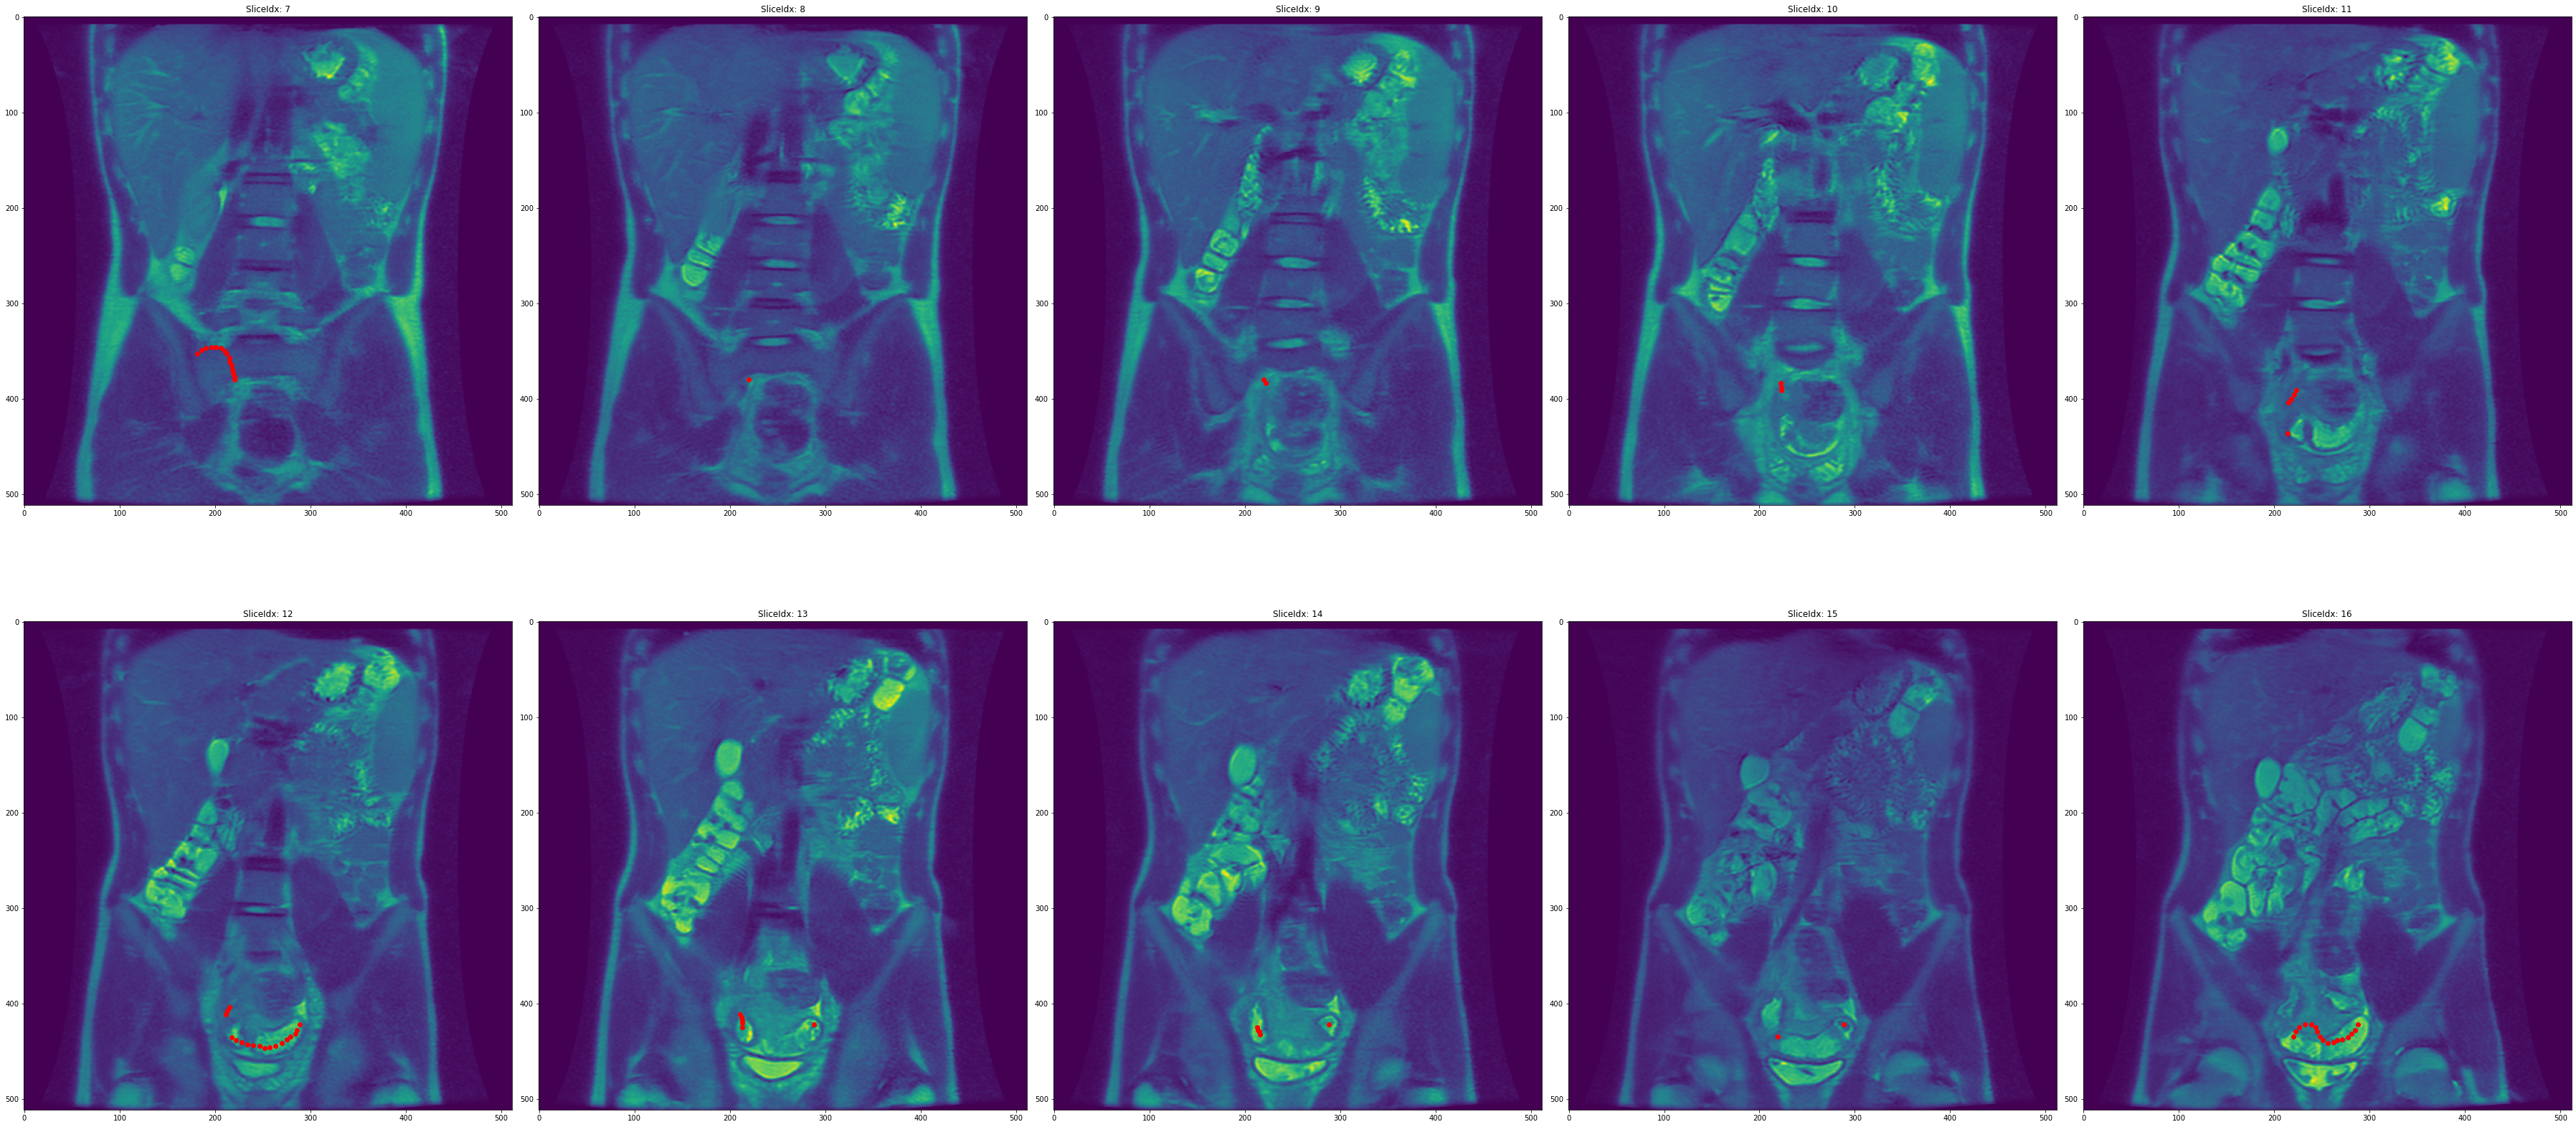

In [21]:
# show all slices
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(50,25))

axs = np.ravel(axs)

for idx, i in enumerate(indices):
    axs[idx].set_title(f'SliceIdx: {i}')
    axs[idx].imshow(nda2[i,:,:])

    for pt in index_data:
        if pt[2] == i:
            axs[idx].plot(pt[0], pt[1], 'ro')
plt.tight_layout()
